# Model comparison with Hirata et al. 

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import numpy 
from matplotlib.pyplot import figure
import pylab 
from cartopy.util import add_cyclic_point
import operator

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import scipy.io as sio
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
from copy import deepcopy
import pandas as pd

In [2]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [4]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [5]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [6]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [7]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

newNCDFfiles = sorted(glob.glob(''+gabyn_path+new_file+'/ocn/hist/'+path_file+new_file+'.pop.h.00'+year+'-*.nc', recursive=True),
                      key=numericalSort)

# 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
newNCDFfiles = sorted(glob.glob(''+new_path+new_file+'/proc/'+path_file+new_file+'.pop.h.0053_0062-*.nc', recursive=True),
                      key=numericalSort)

In [8]:
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## Catagorizing plankton 

| initials  | Name                      | Diameter           |
|-----------|---------------------------|--------------------|
| `mp`      | Microplankton             | >20 $\mu m$        |
| `np`      | Nanoplaknton              | 2 - 20 $\mu m$     |
| `pp`      | Picoplankton              | 0.2 - 2 $\mu m$    |

## Radius from the plankton groups, from "plankton_input_data.cvs". multipied by 2, to create their diameters. 
these are in units of $\mu m$ 

In [9]:
diaz_d  = 3.083335 *2 
picop_d = 0.359997930637595*2 
mp1_d   = 2.07846398860374*2 
mp2_d   = 12.0001038457953*2 
mp3_d   = 69.2831307636024*2 
mp4_d   = 400.009222427549*2 
diat1_d = 9.99930934816372*2 
diat2_d = 44.71981562536*2 
diat3_d = 200.000003993621*2

| Variable  | plankton composition      | Diameter           |
|-----------|---------------------------|--------------------|
| `mp1`     |mp2, mp3, mp4, diat2, diat3| >20 $\mu m$        |
| `np1`     | diaz, mp1, diat1          | 2 - 20 $\mu m$     |
| `pp1`     | pp                        | 0.2 - 2 $\mu m$    |

| Variable  | plankton composition      | 
|-----------|---------------------------|
| `l`      | mp3, mp4, diat3,diat2| 
| `m`     | diat1,mp2,diaz          | 
| `s`     | pp, mp1     | 

# Chl %
### this will be calculated by -> $\frac{Chla_{size}}{Chla_{total}}$

In [10]:
## creating a colorbar 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(70, 70)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=70)
        fig.colorbar(psm, ax=ax)
    plt.show()

In [11]:
colorss = ["black", "blueviolet", "blue", "lightskyblue", "lime", "greenyellow", "yellow", "orange", "orangered"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colorss)

In [12]:
pp1 = ds.ppChl
mp1 = ds.mp2Chl + ds.mp3Chl + ds.mp4Chl+ ds.diat2Chl + ds.diat3Chl
np1 = ds.diazChl + ds.mp1Chl + ds.diat1Chl
p_total = pp1+mp1+np1
pp_frac = (pp1/p_total)*100 
mp_frac = (mp1/p_total)*100
np_frac = (np1/p_total)*100

In [13]:
lev = np.arange(0,71,1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=35)

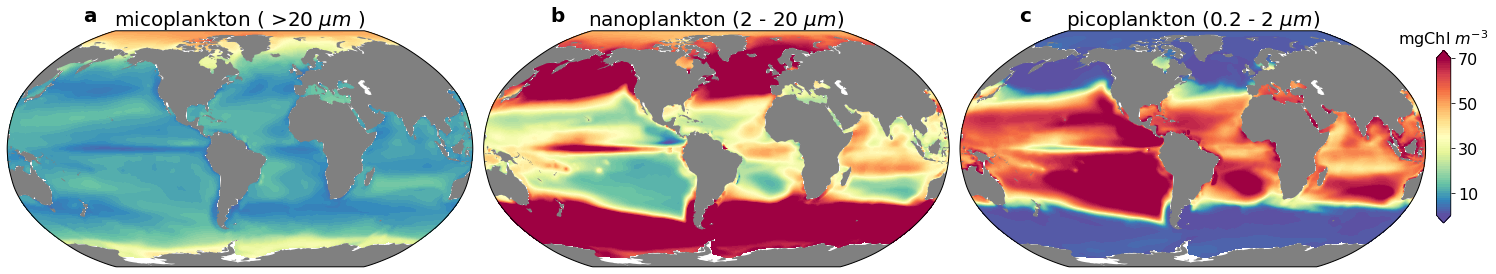

In [14]:
fig = plt.figure(figsize=(20, 8))
lon, lat, chln = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(mp_frac[:,0,:,:], axis=0))
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln, vmin=0, vmax=70,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('micoplankton ( >20 $\mu m$ )', fontsize=20);
fig.text(0.385, 0.95, 'b',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, chln = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(np_frac[:,0,:,:], axis=0))
cf = ax.contourf(lon, lat, chln, vmin=0, vmax=70,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('nanoplankton (2 - 20 $\mu m$)', fontsize=20);
fig.text(0.06, 0.95, 'a',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, chln = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(pp_frac[:,0,:,:], axis=0))
cf = ax.contourf(lon, lat, chln, vmin=0, vmax=70,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('picoplankton (0.2 - 2 $\mu m$)', fontsize=20);
fig.text(0.71, 0.95, 'c',fontsize=20, fontweight='bold')

cb_ax = fig.add_axes([1, 0.6, 0.01, 0.3])
cbar = fig.colorbar(cf, ticks=[10,30,50,70],cax=cb_ax, shrink=0.5)
cbar.ax.set_title('mgChl $m^{-3}$', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/percent_pico_Chla'+year+'year.png',dpi=600, bbox_inches='tight')

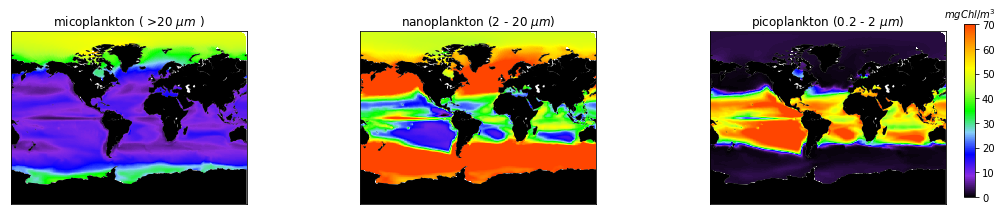

In [15]:
fig = plt.figure(figsize=(15, 3))

#microplankton
ax = fig.add_subplot(131) 
ax.set_title("micoplankton ( >20 $\mu m$ )")
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, pp = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(mp_frac[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
m.fillcontinents(color='black')
cf = m.pcolormesh(x,y,pp,cmap=cmap1, vmin = 0, vmax = 70)

# nanoplankto
ax = fig.add_subplot(132) 
ax.set_title("nanoplankton (2 - 20 $\mu m$)")
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, pp = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(np_frac[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
m.fillcontinents(color='black')
cf = m.pcolormesh(x,y,pp,cmap=cmap1, vmin = 0, vmax = 70)

#picoplankton
ax = fig.add_subplot(133) 
ax.set_title("picoplankton (0.2 - 2 $\mu m$)")
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, pp = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(pp_frac[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
m.fillcontinents(color='black')
cf = m.pcolormesh(x,y,pp,cmap=cmap1, vmin = 0, vmax = 70)

cb_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])
cbar = fig.colorbar(cf, cax=cb_ax, shrink=0.5)
cbar.ax.set_title('$mg Chl/m^3$', fontsize = 10)
fig.tight_layout()

In [16]:
pp1 = ds.ppChl + ds.mp1Chl
mp1 = ds.mp3Chl + ds.mp4Chl+ ds.diat3Chl+ ds.diat2Chl
np1 = ds.diat1Chl +  ds.mp2Chl+ ds.diazChl
p_total = pp1+mp1+np1
pp_frac = (pp1/p_total)*100 
mp_frac = (mp1/p_total)*100
np_frac = (np1/p_total)*100

In [17]:
lev = np.arange(0,101,1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)

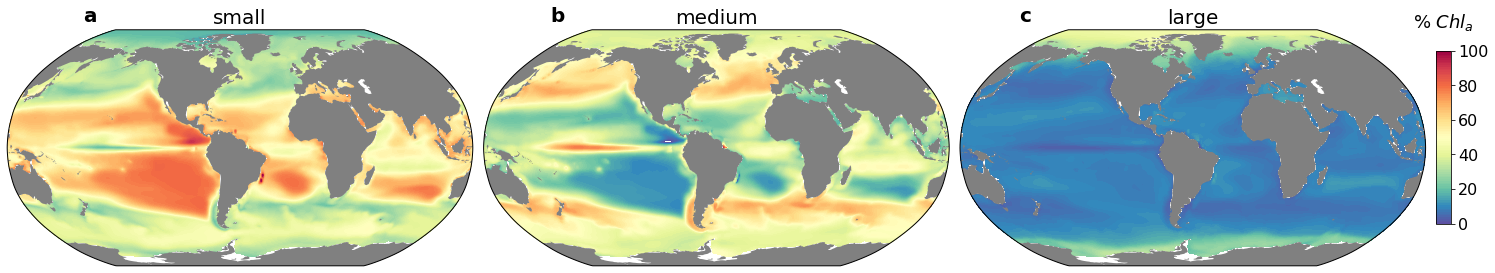

In [18]:
fig = plt.figure(figsize=(20, 8))
lon, lat, chln = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(mp_frac[:,0,:,:], axis=0))
ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln, vmin=0, vmax=100,levels=lev,norm=norm,cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('large', fontsize=20);
fig.text(0.385, 0.95, 'b',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, chln = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(np_frac[:,0,:,:], axis=0))
cf = ax.contourf(lon, lat, chln, vmin=0, vmax=100,levels=lev,norm=norm,cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('medium', fontsize=20);
fig.text(0.06, 0.95, 'a',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, chln = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(pp_frac[:,0,:,:], axis=0))
cf = ax.contourf(lon, lat, chln, vmin=0, vmax=100,levels=lev,norm=norm,cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('small', fontsize=20);
fig.text(0.71, 0.95, 'c',fontsize=20, fontweight='bold')

cb_ax = fig.add_axes([1, 0.6, 0.01, 0.3])
cbar = fig.colorbar(cf, ticks=[0,20,40,60, 80, 100],cax=cb_ax, shrink=0.5)
cbar.ax.set_title('% $Chl_a$', fontsize = 18, y=1.25, pad=-20)
cbar.ax.tick_params(labelsize=16)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/percent_Chla'+year+'year.png',dpi=600, bbox_inches='tight')

In [19]:
lev = [0.01,0.02,0.05,0.1,0.2,0.5,1]
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.1)

In [20]:
lev

[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

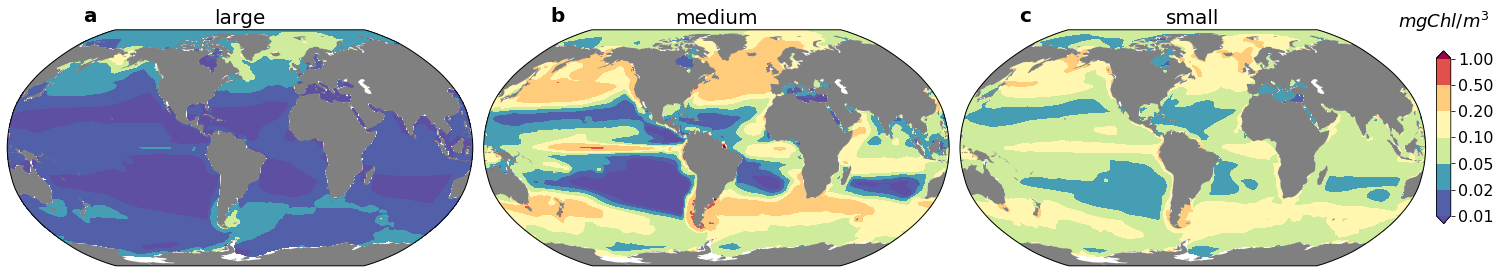

In [21]:
fig = plt.figure(figsize=(20, 8))
lon, lat, chln = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(mp1[:,0,:,:], axis=0))
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, chln, norm=norm,levels = lev,cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('large', fontsize=20);
fig.text(0.385, 0.95, 'b',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, chln = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(np1[:,0,:,:], axis=0))
cf = ax.contourf(lon, lat, chln, norm=norm,levels = lev,cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('medium', fontsize=20);
fig.text(0.06, 0.95, 'a',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, chln = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(pp1[:,0,:,:], axis=0))
cf = ax.contourf(lon, lat, chln,norm=norm,levels = lev, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('small', fontsize=20);
fig.text(0.71, 0.95, 'c',fontsize=20, fontweight='bold')

cb_ax = fig.add_axes([1, 0.6, 0.01, 0.3])
cbar = fig.colorbar(cf, cax=cb_ax, shrink=0.5,extend='both')
cbar.ax.set_title('$mg Chl/m^3$', fontsize = 18, y=1.25, pad=-20)
cbar.ax.tick_params(labelsize=16)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chla_phyto'+year+'year.png',dpi=600, bbox_inches='tight')

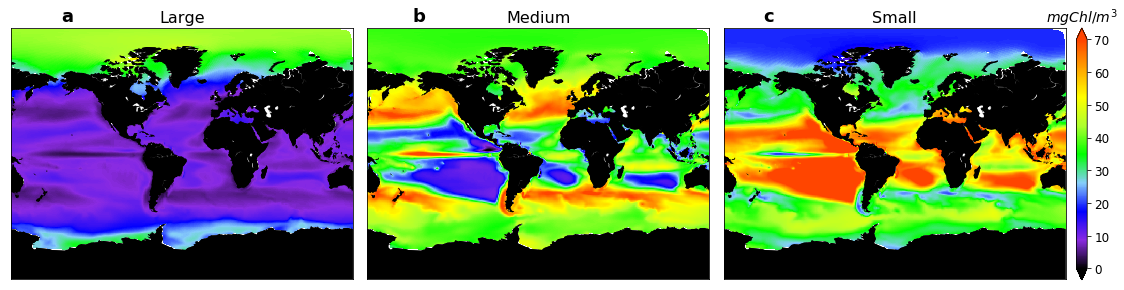

In [22]:
fig = plt.figure(figsize=(15, 5))

#microplankton
ax = fig.add_subplot(131) 
ax.set_title("Large", fontsize=16)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='black')
tlon, tlat, pp = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(mp_frac[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
m.fillcontinents(color='black')
cf = m.pcolormesh(x,y,pp,cmap=cmap1, vmin = 0, vmax = 70)
fig.text(0.385, 0.87, 'b',fontsize=18, fontweight='bold')
# nanoplankto
ax = fig.add_subplot(132) 
ax.set_title("Medium", fontsize=16)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='black')
tlon, tlat, pp = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(np_frac[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
m.fillcontinents(color='black')
cf = m.pcolormesh(x,y,pp,cmap=cmap1, vmin = 0, vmax = 70)
fig.text(0.06, 0.87, 'a',fontsize=18, fontweight='bold')
#picoplankton
ax = fig.add_subplot(133) 
ax.set_title("Small", fontsize=16)
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-220,urcrnrlon=140,resolution='c')
m.fillcontinents(color='black')
tlon, tlat, pp = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(pp_frac[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
m.fillcontinents(color='black')
cf = m.pcolormesh(x,y,pp,cmap=cmap1, vmin = 0, vmax = 70)
fig.text(0.71, 0.87, 'c',fontsize=18, fontweight='bold')
cb_ax = fig.add_axes([1, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cf, cax=cb_ax, shrink=0.5, extend='both')
cbar.ax.set_title('$mg Chl/m^3$', fontsize = 14)
cbar.ax.tick_params(labelsize=12)
fig.tight_layout()
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chla_kind_fraction_percent_'+year+'year.png',dpi=600, bbox_inches='tight')